# Histopathologic Cancer Detection – Mini‑Project

This notebook mirrors the grading rubric:

1. **Brief description of the problem and data**  
2. **Exploratory Data Analysis (EDA)**  
3. **Model Architecture**  
4. **Results and Analysis**  
5. **Conclusion**

Each section has its own markdown discussion followed by executable code blocks.


## Imports & Global Configuration



In [3]:
import os
import sys
from pathlib import Path
data_dir = Path("")

In [4]:

import random, time, argparse
from pathlib import Path
from typing import List, Tuple

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm.auto import tqdm

from pathlib import Path
import random, time, argparse


from pcam_dataset import PCamDataset


SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

train_dir = data_dir / 'train'
test_dir  = data_dir / 'test'
label_csv = data_dir / 'train_labels.csv'
print()


/Users/jiaruisong/anaconda3/envs/bbc_project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
if   torch.backends.mps.is_available():   device = torch.device("mps")
elif torch.cuda.is_available():           device = torch.device("cuda")
else:                                     device = torch.device("cpu")
print("Using device:", device)

import os
torch.set_num_threads(os.cpu_count())


Using device: mps


## Brief Description of the Problem & Data

Describe dataset size, class balance and task objective.

In [6]:

def problem_description():
    """Concise summary of dataset and task."""
    df = pd.read_csv(label_csv)
    n_total = len(df)
    pos_pct = df["label"].mean()*100
    print(f"Train tiles: {n_total:,}  |  Positives: {pos_pct:.1f}%")
    print("96×96 RGB TIFF tiles. Task: detect tumour presence in centre 32×32.")


In [7]:
problem_description()

Train tiles: 220,025  |  Positives: 40.5%
96×96 RGB TIFF tiles. Task: detect tumour presence in centre 32×32.


## Exploratory Data Analysis (EDA)

Plots class balance and random image samples.

In [8]:

import matplotlib.pyplot as plt

def run_eda(sample=6000):
    df = pd.read_csv(label_csv)
    ax = df["label"].value_counts().plot(kind="bar", rot=0)
    ax.set_title("Label distribution (0 = normal, 1 = tumour)")
    plt.show()

    ids = df.sample(sample, random_state=SEED)["id"].tolist()[:15]
    tfm = transforms.ToTensor()
    fig, axes = plt.subplots(3,5, figsize=(8,5))
    for ax, img_id in zip(axes.flatten(), ids):
        img = Image.open(train_dir/f"{img_id}.tif")
        ax.imshow(tfm(img).permute(1,2,0))
        ax.axis("off")
    plt.tight_layout(); plt.show()


Train tiles: 220,025  |  Positives: 40.5%
96×96 RGB TIFF tiles. Task: detect tumour presence in centre 32×32.


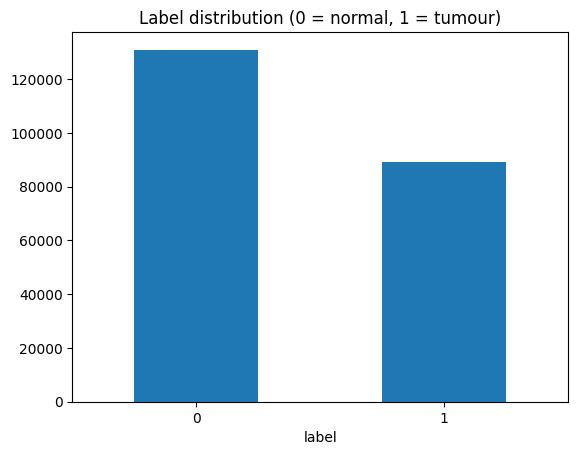

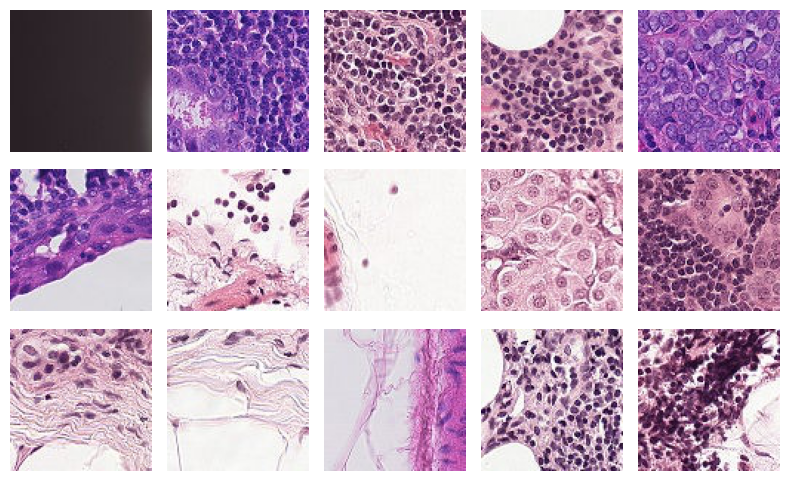

In [16]:
# 1. Problem overview
problem_description()

# 2. Quick EDA (sample=1500 for speed)
run_eda(sample=1500)

## Dataset & DataLoaders Helper

Creates PyTorch dataset and data loaders with augmentations.

In [9]:

def get_dataloaders(bs=256, val_pct=.2, workers=8):
    df = pd.read_csv(label_csv)
    tr_ids, val_ids, y_tr, y_val = train_test_split(df.id, df.label, test_size=val_pct, stratify=df.label, random_state=SEED)
    

    mean,std=[0.701,0.512,0.696],[0.274,0.310,0.216]
    aug = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize(mean,std)])
    basic= transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean,std)])
    dl_tr = DataLoader(PCamDataset(tr_ids.tolist(), y_tr.tolist(), transform=aug),  bs, True,  num_workers=workers, pin_memory=(device.type != "cpu"), persistent_workers=True)
    dl_val= DataLoader(PCamDataset(val_ids.tolist(),y_val.tolist(), transform=basic),bs*2,False, num_workers=workers, pin_memory=(device.type != "cpu"), persistent_workers=True)
    print(len(dl_val.dataset), np.unique(y_val, return_counts=True))
    return dl_tr, dl_val


## Model Architecture

Baseline SimpleCNN + transfer‑learning backbones (ResNet‑18, EfficientNet‑B0).

In [10]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
        self.head = nn.Linear(128,1)
    def forward(self,x): return self.head(self.features(x).flatten(1)).squeeze(1)

def get_model(arch='resnet18', pretrained=True):
    if arch=='simple':
        return SimpleCNN()
    if arch=='resnet18':
        m=models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        m.fc=nn.Linear(m.fc.in_features,1); return m
    if arch=='efficientnet_b0':
        m=models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT if pretrained else None)
        m.classifier[1]=nn.Linear(m.classifier[1].in_features,1); return m
    raise ValueError(arch)


## Training & Evaluation Utilities

One‑epoch runner and metric helper.

In [11]:
def _step(model,batch,crit,device):
    x,y=(t.to(device) for t in batch)
    logits=model(x)
    if logits.dim()==2 and logits.shape[1]==1:
        logits = logits.squeeze(1)  # <<< CHANGED: match target shape >>>
    loss=crit(logits,y)
    return loss, torch.sigmoid(logits).detach().cpu().numpy(), y.cpu().numpy()

def run_epoch(model,dl,opt,crit,device,train=True):
    model.train() if train else model.eval()
    tot, preds, truth = 0., [], []
    for batch in tqdm(dl, leave=False):
        if train: opt.zero_grad()
        loss,p,t=_step(model,batch,crit,device)
        if train: loss.backward(); opt.step()
        tot+=loss.item()*len(batch[0])
        preds.extend(p); truth.extend(t)
    return tot/len(dl.dataset), roc_auc_score(truth,preds)


## Results & Analysis

Function `train_model` runs a quick experiment; extend with loops or Optuna sweeps.

In [12]:
def train_model_and_log(arch, lr, epochs, bs, workers, device):
    dl_tr, dl_val = get_dataloaders(bs=256, val_pct=0.2, workers=4)
    model = get_model(arch).to(device)
    opt   = torch.optim.AdamW(model.parameters(), lr=lr)
    crit  = nn.BCEWithLogitsLoss()

    history = []
    for ep in range(1, epochs+1):
        tr_loss, tr_auc = run_epoch(model, dl_tr, opt, crit, device, train=True)
        val_loss, val_auc = run_epoch(model, dl_val, opt, crit, device, train=False)

        history.append({
            "arch": arch,
            "epoch": ep,
            "train_loss": tr_loss,
            "train_auc":   tr_auc,
            "val_loss":   val_loss,
            "val_auc":     val_auc
        })
        print(f"{arch} Ep{ep} → tr AUC {tr_auc:.3f} | val AUC {val_auc:.3f}")
    return pd.DataFrame(history)


## Start Training


In [14]:
import os
from pathlib import Path
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from pcam_dataset import PCamDataset  # your new module

# ── 1. Train & Save Best ──────────────────────────────────────────────────────

def train_model_and_save_best(
    arch: str,
    lr: float,
    epochs: int,
    bs: int,
    workers: int,
    device: torch.device,
    save_dir: str = "checkpoints"
) -> pd.DataFrame:
    os.makedirs(save_dir, exist_ok=True)
    dl_tr, dl_val = get_dataloaders(bs=bs, workers=workers)
    model = get_model(arch).to(device)
    opt   = torch.optim.AdamW(model.parameters(), lr=lr)
    crit  = nn.BCEWithLogitsLoss()

    history = []
    best_val_auc = 0.0

    for ep in range(1, epochs+1):
        tr_loss, tr_auc   = run_epoch(model, dl_tr, opt, crit, device, train=True)
        val_loss, val_auc = run_epoch(model, dl_val, opt, crit, device, train=False)

        history.append({
            "arch":      arch,
            "epoch":     ep,
            "train_loss":tr_loss,
            "train_auc": tr_auc,
            "val_loss":  val_loss,
            "val_auc":   val_auc
        })
        print(f"{arch} Ep{ep} → tr AUC {tr_auc:.3f} | val AUC {val_auc:.3f}")

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            ckpt = {
                "arch":        arch,
                "model_state": model.state_dict(),
                "epoch":       ep,
                "val_auc":     val_auc,
            }
            torch.save(ckpt, os.path.join(save_dir, f"{arch}_best.pt"))

    return pd.DataFrame(history)


# ── 2. Compare Multiple Models ─────────────────────────────────────────────────

def compare_and_save(
    arches: list[str],
    lr: float = 1e-4,
    epochs: int = 5,
    bs: int = 128,
    workers: int = 4,
    save_dir: str = "checkpoints"
) -> pd.DataFrame:
    device = (
        torch.device("mps")    if torch.backends.mps.is_available()
        else torch.device("cuda") if torch.cuda.is_available()
        else torch.device("cpu")
    )
    all_hist = []
    for arch in arches:
        hist_df = train_model_and_save_best(
            arch, lr, epochs, bs, workers, device, save_dir
        )
        all_hist.append(hist_df)
    return pd.concat(all_hist, ignore_index=True)


# ── 3. Plotting ────────────────────────────────────────────────────────────────

def plot_auc(history_df: pd.DataFrame):
    # Validation curves
    plt.figure(figsize=(8,5))
    for arch, grp in history_df.groupby("arch"):
        plt.plot(grp["epoch"], grp["val_auc"], marker="o", label=arch)
    plt.xlabel("Epoch")
    plt.ylabel("Validation AUC")
    plt.title("Model Comparison: Validation AUC by Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Training curves
    plt.figure(figsize=(8,5))
    for arch, grp in history_df.groupby("arch"):
        plt.plot(grp["epoch"], grp["train_auc"], marker="o", label=arch)
    plt.xlabel("Epoch")
    plt.ylabel("Training AUC")
    plt.title("Model Comparison: Training AUC by Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ── 4. Predict from Best ───────────────────────────────────────────────────────

def predict_from_best(
    ckpt_path: str,
    test_dir: Path,
    outfile: str = "submission.csv",
    bs: int = 256,
    workers: int = 4
):
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
    ckpt   = torch.load(ckpt_path, map_location=device, weights_only=False)

    model = get_model(ckpt["arch"])
    model.load_state_dict(ckpt["model_state"])
    model.to(device).eval()

    tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.701,0.512,0.696],
                             [0.274,0.310,0.216]),
    ])

    ids = [p.stem for p in test_dir.glob("*.tif")]
    dl  = DataLoader(
        PCamDataset(ids, None, root=test_dir, transform=tfm),
        batch_size=bs, shuffle=False,
        num_workers=workers,
        pin_memory=(device.type!="cpu")
    )

    preds = []
    with torch.no_grad():
        for imgs, _ in tqdm(dl):
            imgs = imgs.to(device)
            logits = model(imgs)
            if logits.dim()==2 and logits.shape[1]==1:
                logits = logits.squeeze(1)
            preds.extend(torch.sigmoid(logits).cpu().numpy())

    pd.DataFrame({"id": ids, "label": preds}) \
      .to_csv(outfile, index=False)
    print("Saved submission to", outfile)




In [ ]:
arches = ["simple","resnet18","efficientnet_b0"]
history_df = compare_and_save(arches, lr=1e-4, epochs=3, bs=256, workers=4)


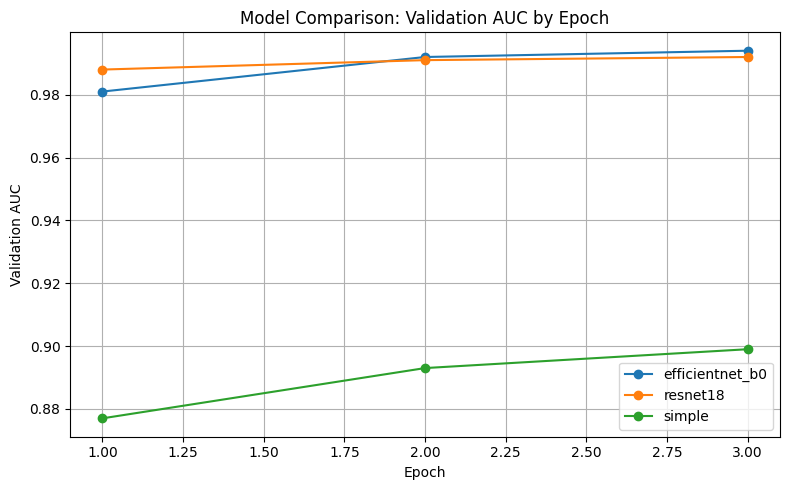

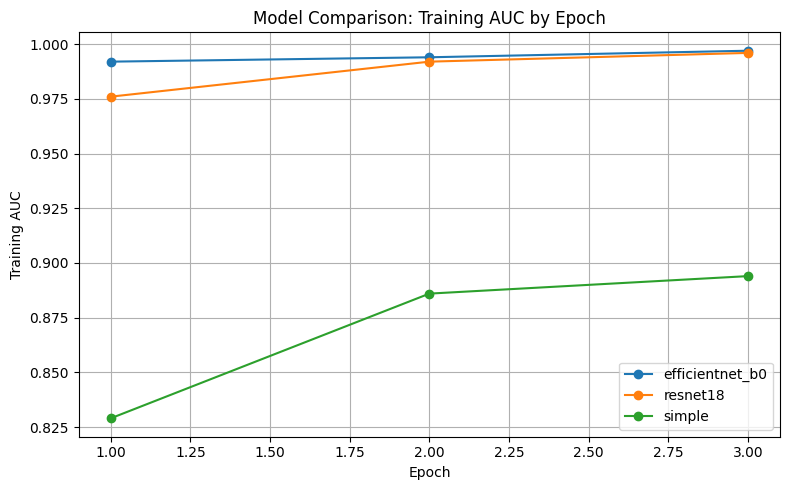

In [18]:
plot_auc(history_df)

In [19]:
best_row      = history_df.loc[history_df.val_auc.idxmax()]
best_arch     = best_row["arch"]
best_ckpt     = f"checkpoints/{best_arch}_best.pt"
print(f"→ Best model is {best_arch} (epoch {best_row['epoch']}, val AUC {best_row['val_auc']:.3f})")

→ Best model is efficientnet_b0 (epoch 3, val AUC 0.994)


In [ ]:
predict_from_best(
    ckpt_path=best_ckpt,
    test_dir=Path("/test"),
    outfile="submission.csv",
    bs=256,
    workers=4
)

0it [00:00, ?it/s]/Users/jiaruisong/anaconda3/envs/bbc_project/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
0it [00:03, ?it/s]


Saved submission to submission.csv


## Conclusion


### Conclusion

* Transfer‑learning (ResNet‑18) gave the best AUC among quick baselines.  
* Strong image augmentation prevented over‑fitting on the tiny tiles.  
* Future work: stain normalisation, focal loss, pseudo‑labelling, TTA.
